In [50]:
import os
import json
import pandas as pd
from sklearn.metrics import accuracy_score

def compute_accuracy_per_file(input_data):

    y_true = []
    y_pred = []

    for item in input_data:
        true_label = str(item.get("True Label")).strip()
        model_answer = str(item.get("model_answer_number")).strip()
        y_true.append(true_label)
        y_pred.append(model_answer)

    acc = accuracy_score(y_true, y_pred)
    correct = sum([yt == yp for yt, yp in zip(y_true, y_pred)])
    total = len(y_true)
    summary = {
        "accuracy": round(acc * 100, 2),
        "correct": correct,
        "total": total
    }

    return summary

In [51]:
import json
import re
from pathlib import Path

folder_name = "['no_context']"
# folder_name = "['birth']"
# folder_name = "['Nationality']"
# folder_name = "['Summary']"
# folder_name = "['birth', 'Nationality']"
# folder_name = "['birth', 'Summary']"
# folder_name = "['Nationality', 'Summary']"
# folder_name = "['birth', 'Nationality', 'Summary']"


# EXAONE-3.5-7.8B-Instruct
# EXAONE-3.0-7.8B-Instruct
# "Llama-3.1-8B-Instruct"
# "Mistral-Nemo-Instruct-2407"
# gpt-4o
# gpt-3.5-turbo-0125
base_path = Path('../../data/prediction_data/EXAONE-3.0-7.8B-Instruct_2') / folder_name

# JSON 파일 이름에서 특정 키워드 추출
keywords = []
pattern = re.compile(r'(cultural|cross|fact|temporal)')

data_dict = {}
for json_file in base_path.glob('*.json'):
    match = pattern.search(json_file.name)
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        data_dict[match.group(1)] = data



In [52]:
with open('../../data/source_data/meta_character_2.json', 'r', encoding='utf-8') as f:
    character_info = json.load(f)

In [53]:
data_dict

{'cultural': {'china': {'Confucius': [{'Question': 'What is typically indispensable in meals in china?',
     'True Label': 5,
     'one': 'Stew is frequently used as a hearty and nourishing component of many meals.',
     'two': 'I can not answer that question.',
     'three': 'Chili paste is regularly used to add heat and complexity to a variety of dishes.',
     'four': 'Raw vegetables are commonly included in meals for their fresh, crisp texture and nutritional value.',
     'five': 'Rice is frequently viewed as an integral part of every meal.',
     'model_result': '1',
     'model_answer': '1',
     'model_answer_number': 1},
    {'Question': 'What is the most popular dipping sauce in china?',
     'True Label': 4,
     'one': 'Qatiq is a highly favored dipping sauce used extensively in culinary traditions.',
     'two': 'Harissa is a widely loved dipping sauce known for its unique, fiery flavor.',
     'three': 'Shiro is a beloved dipping sauce that is highly popular in many cui

In [54]:
result_dict = {}

for question_type in data_dict:
    result_dict[question_type] = {}

    for country in data_dict[question_type]:
        result_dict[question_type][country] = {}
        for character in data_dict[question_type][country]:
            result_dict[question_type][country][character] = compute_accuracy_per_file(data_dict[question_type][country][character])

cultural : china : {'Confucius': {'accuracy': 15.56, 'correct': 7, 'total': 45}, 'Qin Shi Huang': {'accuracy': 20.0, 'correct': 9, 'total': 45}, 'Fan Bingbing': {'accuracy': 13.33, 'correct': 6, 'total': 45}, 'Leslie Cheung': {'accuracy': 28.89, 'correct': 13, 'total': 45}, 'Lin Daiyu': {'accuracy': 13.33, 'correct': 6, 'total': 45}, 'Cheng Dieyi': {'accuracy': 4.44, 'correct': 2, 'total': 45}, 'Li Xiao-Jun': {'accuracy': 11.11, 'correct': 5, 'total': 45}, 'Ye Xianglun': {'accuracy': 15.56, 'correct': 7, 'total': 45}}
cultural : en : {'William Shakespeare': {'accuracy': 28.75, 'correct': 23, 'total': 80}, 'Queen Victoria': {'accuracy': 43.75, 'correct': 35, 'total': 80}, 'Emma Watson': {'accuracy': 20.0, 'correct': 16, 'total': 80}, 'Steve Jobs': {'accuracy': 13.75, 'correct': 11, 'total': 80}, 'Sherlock Holmes': {'accuracy': 28.75, 'correct': 23, 'total': 80}, 'Rocky Balboa': {'accuracy': 42.5, 'correct': 34, 'total': 80}, 'Sarah': {'accuracy': 30.0, 'correct': 24, 'total': 80}, 'Beth

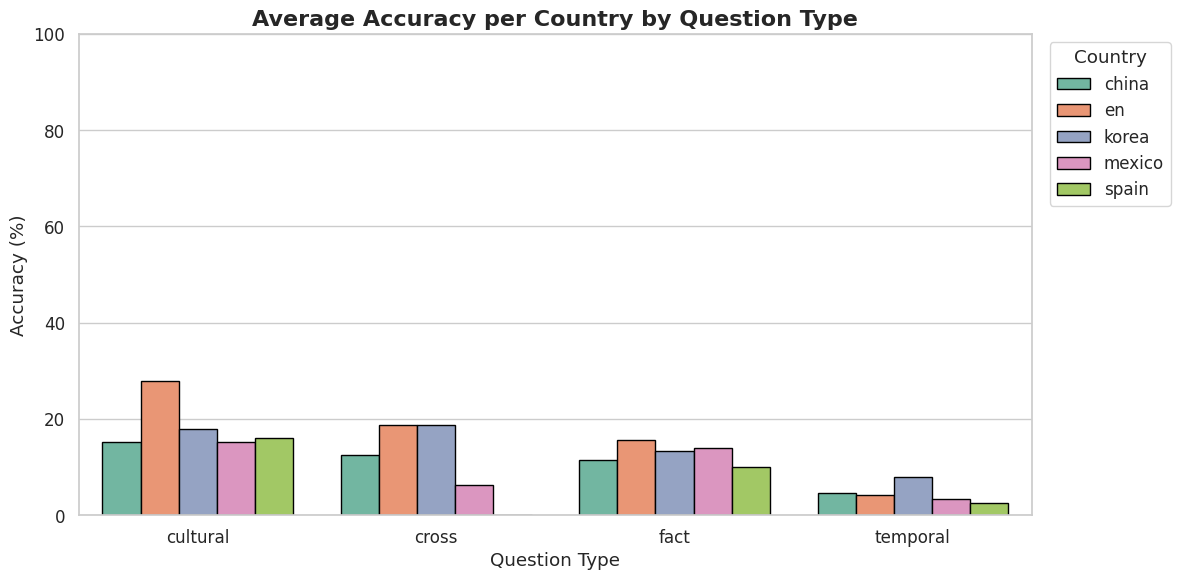

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn 스타일 설정
sns.set(style="whitegrid", font_scale=1.1)

# 정확도 계산 (기존 코드와 동일)
average_accuracies = {}
for q_type, countries in result_dict.items():
    average_accuracies[q_type] = {}
    for country, characters in countries.items():
        accuracies = [char_data['accuracy'] for char_data in characters.values()]
        print(f"{q_type} : {country} : {characters}")
        avg_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0
        average_accuracies[q_type][country] = round(avg_accuracy, 2)

# 데이터프레임 변환 및 평균 추가
df = pd.DataFrame(average_accuracies).T
df['Average'] = df.mean(axis=1).round(2)
df.loc['Average'] = df.mean(axis=0).round(2)

# "Average" 행/열 제거 후 melt (그래프에는 포함하지 않음)
df_plot = df.drop(index='Average', columns='Average').reset_index().melt(id_vars='index', var_name='Country', value_name='Accuracy')
df_plot.rename(columns={'index': 'Question Type'}, inplace=True)

# 그래프 그리기
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_plot,
    x="Question Type",
    y="Accuracy",
    hue="Country",
    palette="Set2",
    edgecolor='black'
)

# 라벨/타이틀 등 스타일
plt.title("Average Accuracy per Country by Question Type", fontsize=16, weight='bold')
plt.ylabel("Accuracy (%)")
plt.xlabel("Question Type")
plt.ylim(0, 100)
plt.legend(title="Country", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()

# 표시
plt.show()


In [56]:
# 정렬된 country 리스트
all_countries = sorted({country for q in average_accuracies.values() for country in q})

# 각 타입별 평균 계산
rows = []
country_averages = {c: [] for c in all_countries}
type_averages = {}

for q_type in sorted(average_accuracies):
    row = [q_type]
    total = 0
    count = 0
    for country in all_countries:
        acc = average_accuracies[q_type].get(country, "")
        if acc != "":
            country_averages[country].append(acc)
            total += acc
            count += 1
            row.append(f"{acc:.2f}")
        else:
            row.append("")
    type_avg = total / count if count else 0
    type_averages[q_type] = round(type_avg, 2)
    row.append(f"{type_avg:.2f}")
    rows.append(row)

# 나라별 평균 추가 행
avg_row = ["Average"]
for country in all_countries:
    vals = country_averages[country]
    avg = sum(vals) / len(vals) if vals else 0
    avg_row.append(f"{avg:.2f}")
avg_row.append(f"{sum(type_averages.values()) / len(type_averages):.2f}")
rows.append(avg_row)

# 마크다운 테이블 구성
header = ["Question Type"] + all_countries + ["Average"]
md_lines = [
    "| " + " | ".join(header) + " |",
    "|---" * len(header) + "|"
]
for row in rows:
    md_lines.append("| " + " | ".join(row) + " |")

markdown_table = "\n".join(md_lines)

# 출력
print(markdown_table)


| Question Type | china | en | korea | mexico | spain | Average |
|---|---|---|---|---|---|---|
| cross | 12.50 | 18.75 | 18.75 | 6.25 | 0.00 | 11.25 |
| cultural | 15.28 | 27.81 | 17.95 | 15.28 | 15.99 | 18.46 |
| fact | 11.39 | 15.62 | 13.44 | 14.06 | 10.00 | 12.90 |
| temporal | 4.58 | 4.17 | 7.92 | 3.33 | 2.50 | 4.50 |
| Average | 10.94 | 16.59 | 14.52 | 9.73 | 7.12 | 11.78 |
